In [4]:
import sys
chione_directory = "/Users/rricker/GitLab/projects/chione"
sys.path.append(chione_directory)
import numpy as np
import netCDF4
from scipy import interpolate
from scipy.interpolate import griddata
import geopandas as gpd
import pandas as pd
import os
import yaml
import glob
from loguru import logger
from pyproj import Proj, transform
from shapely.geometry import Point
from scipy.spatial import cKDTree
from typing import Tuple
#from io_tools import transform_coords
import matplotlib.pyplot as plt
import pyproj
import geopandas as gpd
import shapely as shp
import datetime
import re
#from gridding import gridding_lib



In [14]:
(2700000*2)/216

25000.0

In [13]:
432/2

216.0

In [70]:
def transform_coords(x: float, y: float, in_epsg: str, out_epsg: str) -> Tuple[float, float]:
    """
    Transforms coordinates from one projection to another using pyproj.

    Args:
        x: The x-coordinate.
        y: The y-coordinate.
        in_epsg: The EPSG code of the input projection.
        out_epsg: The EPSG code of the output projection.

    Returns:
        A tuple of the transformed (x, y) coordinates.
    """
    source_crs = pyproj.CRS(in_epsg)
    destination_crs = pyproj.CRS(out_epsg)
    transformer = pyproj.Transformer.from_crs(source_crs, destination_crs, always_xy=True)
    return transformer.transform(x, y)

def define_grid(xmin, ymin, xmax, ymax, n_cells, epsg):
    cell_size = (xmax - xmin) / n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax, cell_size):
        for y0 in np.arange(ymin, ymax, cell_size):
            # bounds
            x1 = x0 + cell_size
            y1 = y0 + cell_size
            grid_cells.append(shp.geometry.box(x0, y0, x1, y1))
    return gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=epsg), cell_size


def grid_data(gdf, grid, var, var_str, hist_n_bins=None, hist_range=None, fill_nan=False, agg_mode=None):

    if agg_mode is None:
        agg_mode = ['mean', 'std']
    tmp_grid = grid.copy()
    merged = gpd.sjoin(gdf[var + ['geometry']].copy(), grid, how='left', op='within')
    if 'mean' in agg_mode: dissolve_mean = merged.dissolve(by='index_right', aggfunc=np.mean)
    if 'std' in agg_mode: dissolve_std = merged.dissolve(by='index_right', aggfunc=np.std)
    if 'sum' in agg_mode: dissolve_sum = merged.dissolve(by='index_right', aggfunc=np.sum)
    if 'cnt' in agg_mode: dissolve_cnt = merged.dissolve(by='index_right', aggfunc='count')
    if 'hist' in agg_mode:
        dissolve_hist = merged.dissolve(by='index_right', aggfunc=np.mean)
        dissolve_hist.reset_index(inplace=True)
        dissolve_hist[var[0]] = ''

    for i in range(0, len(var)):
        if 'mean' in agg_mode: tmp_grid.loc[dissolve_mean.index, var_str[i]] = dissolve_mean[var[i]].values
        if 'std' in agg_mode: tmp_grid.loc[dissolve_std.index, var_str[i] + '_std'] = dissolve_std[var[i]].values
        if 'sum' in agg_mode: tmp_grid.loc[dissolve_sum.index, var_str[i] + '_sum'] = dissolve_sum[var[i]].values
        if 'cnt' in agg_mode: tmp_grid.loc[dissolve_cnt.index, var_str[i] + '_cnt'] = dissolve_cnt[var[i]].values

        if 'hist' in agg_mode:
            for j in dissolve_hist.index_right.unique():
                tmp = merged[merged.index_right == j].drop(['index_right', 'geometry'], axis=1).reset_index(drop=True)
                tmp_hist = np.histogram(np.array(tmp[var[i]]),
                                        bins=hist_n_bins,
                                        range=(hist_range[0],hist_range[1]))[0]
                dissolve_hist[var[i]][dissolve_hist.index[dissolve_hist.index_right == j][0]] = ' '.join(
                    map(str, tmp_hist))

            tmp_grid.loc[dissolve_hist.index_right, var_str[i] + '_hist'] = dissolve_hist[var[i]].values

    if not fill_nan:
        tmp_grid = tmp_grid.dropna()

    centroidseries = tmp_grid['geometry'].centroid
    tmp_grid['x'], tmp_grid['y'] = centroidseries.x, centroidseries.y
    tmp_grid = tmp_grid.set_index(['x', 'y'])
    return tmp_grid

In [71]:
with open('/Users/rricker/GitLab/projects/chione/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [72]:
def interpolate_growth(data, interp_var, growth_range, grid, cell_width):
    
    merged = gpd.sjoin(data, grid, how='left', op='within')
    geo = merged.groupby(['index_right', 'dt_days'], as_index=False).first()['geometry']
    tmp = merged.groupby(['index_right', 'dt_days'], as_index=False).mean().assign(geometry=geo)
    n_tiepoints = tmp.groupby('index_right')['dt_days'].count()
    valid_indices = n_tiepoints[n_tiepoints >= 3].index
    tmp = tmp[tmp['index_right'].isin(valid_indices)]
    tmp.set_index('index_right', inplace=True)
    
    # define parameters for growth interpolation
    eps = 1.8
    nbs = 260
    fsm = interpolate.interp1d(np.array([40.0, 90.0]), np.array([80, 10]))

    # perform linear fit
    tmp['coeff'] = tmp.groupby('index_right').apply(lambda x: np.polyfit(x['dt_days'], x[interp_var], deg=1, cov=True))

    tmp['growth'] = [x[0][0] for x in tmp['coeff'].values]
    tmp['growth_unc'] = [np.sqrt(np.diag(x[1])[1]) for x in tmp['coeff'].values] 
    tmp[(tmp['growth'] > growth_range[1]) | (tmp['growth'] < growth_range[0])] = np.nan
    tmp = tmp.drop(columns=['coeff'])
    tmp.index.names = ['index']

    # gridding of growth coefficients
    growth_grid = grid_data(tmp, grid, ['growth','growth_unc'], ['growth','growth_unc'], fill_nan=True)

    centroidseries = growth_grid['geometry'].centroid
    growth_grid['yc'], growth_grid['xc'] = centroidseries.x, centroidseries.y
        
    # interpolation of growth for all valid target variable data points
    f_growth = interpolate.RBFInterpolator(np.vstack((np.array(growth_grid.dropna()['yc']),
                                                      np.array(growth_grid.dropna()['xc']))).transpose(),
                                           np.array(growth_grid.dropna()['growth']),
                                           neighbors=nbs,
                                           smoothing=fsm(
                                               np.array(growth_grid.dropna().geometry.centroid.to_crs(4326).geometry.y)),
                                           kernel='gaussian', epsilon=eps * 1 / cell_width)
    
    f_growth_unc = interpolate.RBFInterpolator(np.vstack((np.array(growth_grid.dropna()['yc']),
                                                          np.array(growth_grid.dropna()['xc']))).transpose(),
                                               np.array(growth_grid.dropna()['growth_unc']),
                                               neighbors=nbs,
                                               smoothing=fsm(
                                                   np.array(growth_grid.dropna().geometry.centroid.to_crs(4326).geometry.y)),
                                               kernel='gaussian', epsilon=eps * 1 / cell_width)
        
    return f_growth, f_growth_unc, growth_grid


target_variable = config["options"]["target_variable"]
geojson_dir = config["dir"][config["options"]["sensor"]]["geojson"]
stk_opt = config['options']['proc_step_options']['stacking']
start_date = stk_opt.get('t_start')
t_series_length = stk_opt.get('t_length')

growth_range = config['options']['proc_step_options']['stacking']['growth_estimation']['growth_range'][
    "freeboard" if "freeboard" in config["options"]["target_variable"] else "thickness"]
min_n_tiepoints = config['options']['proc_step_options']['stacking']['growth_estimation']['min_n_tiepoints']
growth_grid_options = config['options']['proc_step_options']['stacking']['growth_estimation']['growth_grid']

list_f = sorted(glob.glob(os.path.join(geojson_dir, f'*-f-*.geojson')))
list_r = sorted(glob.glob(os.path.join(geojson_dir, f'*-r-*.geojson')))

grid, cell_width = define_grid(
    growth_grid_options["bounds"][0],
    growth_grid_options["bounds"][1],
    growth_grid_options["bounds"][2],
    growth_grid_options["bounds"][3],
    growth_grid_options["dim"],
    config['options']['out_epsg'])

In [26]:
%%time

nbs = 260
#for j in range(t_series_length):
j=1
cday = start_date + datetime.timedelta(days=j)
subs = cday.strftime("%Y%m%d")
file_f = [i for i in list_f if subs in re.search('-(.+?)-*.geojson', os.path.basename(i)).group(1)]
file_r = [i for i in list_r if subs in re.search('-(.+?)-*.geojson', os.path.basename(i)).group(1)]
print(file_f)
stack_f = gpd.read_file(file_f[0])
stack_r = gpd.read_file(file_r[0])
stack_r = stack_r[stack_r.dt_days != 0].reset_index(drop=True)
data = pd.concat([stack_f, stack_r], ignore_index=True)

# apply growth correction
traj_geom = data['geometry']
target_location = data["geometry"].apply(lambda g: g.geoms[-1])
data["geometry"] = target_location

#merged = gpd.sjoin(data, grid, how='left', op='within')
#geo = merged.groupby(['index_right', 'dt_days'], as_index=False).first()['geometry']
#tmp = merged.groupby(['index_right', 'dt_days'], as_index=False).mean().assign(geometry=geo)
#n_tiepoints = tmp.groupby('index_right')['dt_days'].count()
#valid_indices = n_tiepoints[n_tiepoints >= 3].index
#tmp = tmp[tmp['index_right'].isin(valid_indices)]
#tmp.set_index('index_right', inplace=True)

f_growth, f_growth_unc, growth_grid = interpolate_growth(tmp, target_variable, growth_range, grid, cell_width)
growth_interpolated = f_growth(np.array([np.array(data.geometry.x), np.array(data.geometry.y)]).transpose())
growth_unc_interpolated = f_growth_unc(np.array([np.array(data.geometry.x), np.array(data.geometry.y)]).transpose())

data[target_variable + "_corr"] = growth_interpolated * (-data.dt_days.to_numpy()) + data[target_variable].to_numpy()
data[target_variable + "_growth_unc"] = (growth_unc_interpolated/np.sqrt(nbs)) * abs(data.dt_days.to_numpy())
data["growth_interpolated"] = growth_interpolated
data[target_variable + "_drift_unc"] = np.sqrt(data[target_variable + "_drift_unc"])

# Create a KDTree for spatial indexing
points = np.array([data['geometry'].x,data['geometry'].y]).transpose()
kdtree = cKDTree(points)

# Function to calculate standard deviation of neighbor sea ice thickness within given radius
def get_neighbor_dyn_range(row, data, var, tree):
    neighbors_indices = tree.query_ball_point((row['geometry'].x, row['geometry'].y), row[var+'_drift_unc'])
    neighbor_thickness = data.loc[neighbors_indices][var]
    return np.percentile(neighbor_thickness, 75)-np.percentile(neighbor_thickness, 25)

# Apply the function to calculate the standard deviation for each point
data["sea_ice_thickness_drift_unc"] = data.apply(get_neighbor_dyn_range,args=(data,target_variable,kdtree), axis=1)

#data["geometry"] = traj_geom

#data.to_file(os.path.join(geojson_dir, os.path.basename(file_f[0]).replace("-f-", "-")), driver="GeoJSON")
#os.remove(file_f[0])
#os.remove(file_r[0])

['/Volumes/data2/projects/chione/product/icesat2/geojson_ex2/sea_ice_thickness-icesat2-nh-20211004-v100-f-100.geojson']


/var/folders/sh/kwy4x62d2mv1cgnwsyd94gzr0000gn/T/ipykernel_66680/2792336315.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3413

  merged = gpd.sjoin(data, grid, how='left', op='within')
/var/folders/sh/kwy4x62d2mv1cgnwsyd94gzr0000gn/T/ipykernel_66680/783061670.py:37: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3413

  merged = gpd.sjoin(gdf[var + ['geometry']].copy(), grid, how='left', op='within')


KeyboardInterrupt: 

In [505]:
# Create a KDTree for spatial indexing
points = np.array([data['geometry'].x,data['geometry'].y]).transpose()
kdtree = cKDTree(points)

var= 'sea_ice_thickness'

# Function to calculate standard deviation of neighbor sea ice thickness within given radius
def get_neighbor_dyn_range(row, data, var, tree):
    neighbors_indices = tree.query_ball_point((row['geometry'].x, row['geometry'].y), row[var+'_drift_unc'])
    neighbor_thickness = data.loc[neighbors_indices][var]
    return np.percentile(neighbor_thickness, 75)-np.percentile(neighbor_thickness, 25)

# Apply the function to calculate the standard deviation for each point
data["sea_ice_thickness_drift_unc"] = data.apply(get_neighbor_dyn_range,args=(data,var,kdtree), axis=1)


In [473]:
growth_unc = data['sea_ice_thickness_growth_unc']
sit_unc = data['sea_ice_thickness_unc']
drift_unc = data['sea_ice_thickness_drift_unc']

<BarContainer object of 100 artists>

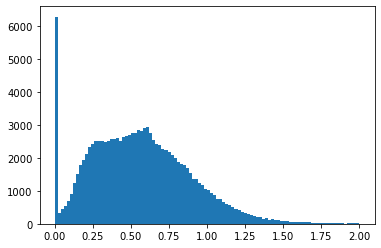

In [506]:
plt.hist(data["sea_ice_thickness_drift_unc"],bins=100, range=(0,2))[2]

<BarContainer object of 100 artists>

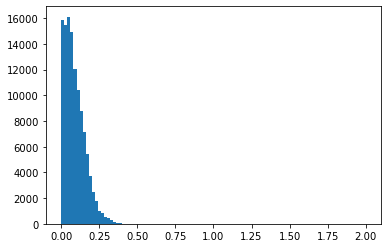

In [448]:
plt.hist(growth_unc,bins=100, range=(0,2))[2]

<BarContainer object of 100 artists>

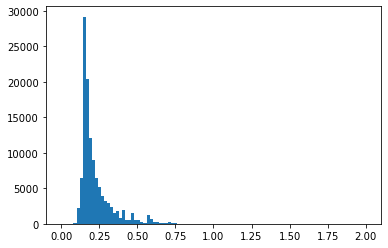

In [449]:
plt.hist(sit_unc,bins=100, range=(0,2))[2]

In [4]:
def grid_data(gdf, grid, var, var_str, hist_n_bins=None, hist_range=None, fill_nan=False, agg_mode=None):

    if agg_mode is None:
        agg_mode = ['mean', 'std']
    tmp_grid = grid.copy()
    merged = gpd.sjoin(gdf[var + ['geometry']].copy(), grid, how='left', op='within')
    if 'mean' in agg_mode:
        dissolve_mean = merged.dissolve(by='index_right', aggfunc=np.mean)
        for i in range(0, len(var)):
            tmp_grid.loc[dissolve_mean.index, var_str[i]] = dissolve_mean[var[i]].values
    if 'std' in agg_mode:
        dissolve_std = merged.dissolve(by='index_right', aggfunc=np.std)
        for i in range(0, len(var)):
            tmp_grid.loc[dissolve_std.index, var_str[i] + '_std'] = dissolve_std[var[i]].values
    if 'sum' in agg_mode:
        dissolve_sum = merged.dissolve(by='index_right', aggfunc=np.sum)
        for i in range(0, len(var)):
            tmp_grid.loc[dissolve_sum.index, var_str[i] + '_sum'] = dissolve_sum[var[i]].values
    if 'cnt' in agg_mode:
        dissolve_cnt = merged.dissolve(by='index_right', aggfunc='count')
        for i in range(0, len(var)):
            tmp_grid.loc[dissolve_cnt.index, var_str[i] + '_cnt'] = dissolve_cnt[var[i]].values
    if 'hist' in agg_mode:
        dissolve_hist = merged.dissolve(by='index_right', aggfunc=np.mean)
        dissolve_hist.reset_index(inplace=True)
        dissolve_hist[var[0]] = ''
        for i in range(0, len(var)):
            for j in dissolve_hist.index_right.unique():
                tmp = merged[merged.index_right == j].drop(['index_right', 'geometry'], axis=1).reset_index(drop=True)
                tmp_hist = np.histogram(np.array(tmp[var[i]]),
                                        bins=hist_n_bins,
                                        range=(hist_range[0], hist_range[1]))[0]
                dissolve_hist[var[i]][dissolve_hist.index[dissolve_hist.index_right == j][0]] = ' '.join(
                    map(str, tmp_hist))

            tmp_grid.loc[dissolve_hist.index_right, var_str[i] + '_hist'] = dissolve_hist[var[i]].values

    if not fill_nan:
        tmp_grid = tmp_grid.dropna()

    centroidseries = tmp_grid['geometry'].centroid
    tmp_grid['x'], tmp_grid['y'] = centroidseries.x, centroidseries.y
    tmp_grid = tmp_grid.set_index(['x', 'y'])
    return tmp_grid


In [119]:
with open('/Users/rricker/GitLab/projects/chione/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

file = '/Volumes/data2/projects/chione/product/icesat2/geojson_ex3/sea_ice_thickness-icesat2-nh-20211017-v100-f-100.geojson'
data = gpd.read_file(file)
target_location = data["geometry"].apply(lambda g: g.geoms[-1])
data["geometry"] = target_location

sensor = config['options']['sensor']
target_var = config['options']['target_variable']
target_var_r = config['options']['target_variable_range']["freeboard" if "freeboard" in target_var else "thickness"]
out_epsg = config["options"]["out_epsg"]
stk_opt = config['options']['proc_step_options']['stacking']

# declare histogram options
hist_n_bins = stk_opt['hist']['n_bins']
hist_range = stk_opt['hist']['range']["freeboard" if "freeboard" in target_var else "thickness"]
hist_bin_size = (hist_range[1] - hist_range[0]) / hist_n_bins

# declare gridding options
gridding_mode = config["options"]['proc_step_options']['gridding']['mode']
out_dir = config['dir'][sensor]['netcdf']

netcdf_bounds = config['options']['proc_step_options']['gridding']['netcdf_grid']['bounds']

grid, cell_width = gridding_lib.define_grid(
    netcdf_bounds,
    config['options']['proc_step_options']['gridding']['netcdf_grid']['dim'],
    config['options']['out_epsg'])

DriverError: /Volumes/data2/projects/chione/product/icesat2/geojson_ex3/sea_ice_thickness-icesat2-nh-20211017-v100-f-100.geojson: No such file or directory

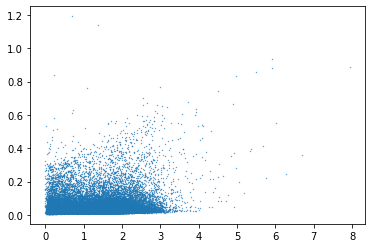

In [9]:
plt.scatter(data['sea_ice_thickness'],data['sea_ice_thickness_unc'],s=0.1)

In [20]:
gdf = data.copy()
gdf['weights'] = 1/(gdf['sea_ice_thickness_unc'])
gdf['weights_p'] = gdf['sea_ice_thickness'] * gdf['weights']

#master = grid_data(gdf, grid, ['weights','weights_p'], ['weights','weights_p'], fill_nan=True, agg_mode=['sum'])
#master['weighted_mean'] = master['weights_p_sum']/ master['weights_sum']
#master['weighted_mean_unc'] = np.sqrt(1 / master['weights_sum'])
#np.mean(master['weighted_mean_unc'])

In [10]:
import pyproj
epsg_code = '3413'
crs = pyproj.CRS.from_epsg(epsg_code)

In [11]:
crs.name

'WGS 84 / NSIDC Sea Ice Polar Stereographic North'

In [20]:
import pyproj
crs = pyproj.CRS.from_epsg(int(config['options']['out_epsg'].split(":")[1]))
crs.name

'WGS 84 / NSIDC Sea Ice Polar Stereographic North'

In [51]:
import os
from datetime import datetime

def create_subdir(config, parent_directory, grid):
    target_variable = config["options"]["target_variable"]
    hem = config["options"]["hemisphere"]
    stk_opt = config['options']['proc_step_options']['stacking']
    t_window = stk_opt['t_window']
    mode = stk_opt['mode']
    epsg = 'epsg' + config['options']['out_epsg'].split(":")[1]
    res = "{:.0f}".format(grid.geometry[0].length / 4 / 100.0)
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    
    sub_dir_name = f'{target_variable}-{hem}-{t_window}{mode}-{epsg}_{res}-{timestamp}'
    sub_dir_path = os.path.join(parent_directory, sub_dir_name)

    os.makedirs(sub_dir_path)
    return sub_dir_path

In [55]:
parent_directory = "/Volumes/data2/projects/chione/product/icesat2/geojson_ex3/"
subdir = create_subdir(config, parent_directory, grid)

In [56]:
subdir

'/Volumes/data2/projects/chione/product/icesat2/geojson_ex3/sea_ice_thickness-nh-16fr-epsg3413_250-2023-08-02_15-18-02'

In [48]:
"{:.0f}".format(grid.geometry[0].length / 4 / 100.0)

'250'

In [59]:
config['options']['proc_step_options']['gridding']['sub_dir']

KeyError: 'sub_dir'

In [61]:
a=[]
b=['c12','a34']
c = a+b
c

['c12', 'a34']

In [67]:
a=['aaa','sdd']
if a:
    print('yes')

yes


In [81]:
target_var = config["options"]["target_variable"]
hem = config["options"]["hemisphere"]
sensor = config['options']['sensor']
out_epsg = config["options"]["out_epsg"]
t0 = datetime.datetime(2020,10,10,0,0,0)
direct = 'f'

outfile = (
    f"{target_var}-{sensor}-{hem}-{t0.strftime('%Y%m%d')}-"
    f"{config['version']}-{direct}-epsg{out_epsg.split(':')[1]}_"
    f"{grid.geometry[0].length / 4 / 100.0:.0f}.geojson"
)

In [82]:
outfile

'sea_ice_thickness-icesat2-nh-20201010-v100-f-epsg6931_250.geojson'

In [104]:
file = '/Volumes/data2/projects/chione/product/icesat2/geojson/sea_ice_thickness-nh-16fr-epsg6931_100-2023-08-02_16-54-27/sea_ice_thickness-icesat2-nh-20211021-v100-epsg6931_100.geojson'
data = gpd.read_file(file)
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [105]:
import re
in_epsg = "epsg:" + re.findall(r'epsg(\d{4})', os.path.basename(file))[0]
data.crs = in_epsg
data.crs

<Projected CRS: EPSG:6931>
Name: WGS 84 / NSIDC EASE-Grid 2.0 North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere.
- bounds: (-180.0, 0.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 North
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [112]:
data.to_crs(crs='epsg:3413', inplace=True)#
data.crs

<Projected CRS: EPSG:3413>
Name: WGS 84 / NSIDC Sea Ice Polar Stereographic North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere - north of 60°N onshore and offshore, including Arctic.
- bounds: (-180.0, 60.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC Sea Ice polar stereographic north
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [114]:
data.to_crs(crs='epsg:3411', inplace=True)#
data.crs

<Projected CRS: EPSG:3411>
Name: NSIDC Sea Ice Polar Stereographic North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere - north of 60°N onshore and offshore, including Arctic.
- bounds: (-180.0, 60.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC Sea Ice polar stereographic north
- method: Polar Stereographic (variant B)
Datum: Not specified (based on Hughes 1980 ellipsoid)
- Ellipsoid: Hughes 1980
- Prime Meridian: Greenwich